In [199]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction import stop_words
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import tree


from imblearn.ensemble import EasyEnsembleClassifier

import re

from urlextract import URLExtract

from scipy.sparse import hstack

import numpy as np

import json

import pickle

import sys

import seaborn as sns

import pydotplus

from IPython.display import Image

sys.path.append('..')
from src.features.build_features import syns, sep_urls, check_paren, repo_label
from src.data.make_dataset import return_passages, test_suitability

# Sequencing Classifiers

In this notebook, I'm bolting on a second level classifier to see how things work out. Basically, we're using a classifier very similar to the high recall one we used last time, but now we're bolting a secondary classifier on after that. This secondary classifier will use some hand-built features along with the predicted probability from the first classifier.

In [89]:
def code_kw(text):
    passage_marked = 0
    
    reg_matches = re.compile(r"""(software)|(tool)|(code)|(package)|(\sR\s)|(python)|
                                 (matlab)|(SPM8)|(implement.)""", re.X|re.VERBOSE)
    
    m = re.search(reg_matches, text.lower())
    if m:
        return(1)
    else:
        return(0)


## Adam's labels
Here, we're looking at the results of labeling the data. These are the labels adam provided in the last round.

In [215]:
df_labeled = pd.read_csv('/data/riddleta/data_sharing_reuse/interim/high_recall_labelling - high_recall_labelling.csv')

In [216]:
df_labeled['recoded_labels'] = df_labeled.n2.replace({'c':0, 'n':0, '2':1, 'd':1, 'n2':0, 'nd':0})

In [218]:
df_labeled.recoded_labels.value_counts()
#159 instances of data statements last time

0    341
1    159
Name: recoded_labels, dtype: int64

How do those data statements look with respect to the presence/absence of keywords that would indicate that it is code that is being shared?

In [6]:
df_labeled['kw_code'] = df_labeled.text.apply(lambda x: code_kw(x))

In [7]:
pd.crosstab(df_labeled.kw_code, df_labeled.n2)

n2,2,c,d,n,n2,nd
kw_code,,,,,,
0,88,58,50,133,12,6
1,7,112,14,20,0,0


In [8]:
df_labeled.n2.value_counts()

c     170
n     153
2      95
d      64
n2     12
nd      6
Name: n2, dtype: int64

## Rerunning the last classifier
Now we rerun the classifier on the original training sample (before the new labels). This is just to familiarize us with what we were working with.

In [202]:
extract = URLExtract()
df = pd.read_csv('/data/riddleta/data_sharing_reuse/external/combined_labels_incomplete.csv')
df.text.fillna('', inplace=True)
df['has_url'] = df.text.apply(lambda x: extract.has_urls(x))
df['has_parenth'] = df.text.apply(lambda x: check_paren(x))
df['repo'] = df.text.apply(lambda x: repo_label(x))
df['text'] = df.text.apply(lambda x: sep_urls(x))
df['syn_text'] = df.text.apply(lambda x: syns(x))
df['all_text'] = df.text + ' ' + df.syn_text

In [206]:
cv = CountVectorizer(stop_words=stop_words.ENGLISH_STOP_WORDS)
enc = OneHotEncoder(handle_unknown='ignore')

x_tr, x_tst, y_tr, y_tst = train_test_split(df.all_text, df.data_statement, test_size=.25, random_state=42, stratify=df.data_statement)

In [207]:
x_train = cv.fit_transform(x_tr)
one_hots_train = enc.fit_transform(df[['section', 'Journal Title', 'Year', 'has_url', 'has_parenth', 'repo']].loc[x_tr.index])
y_train = df.data_statement[x_tr.index]
x_test = cv.transform(df.all_text[x_tst.index])
one_hots_test = enc.transform(df[['section', 'Journal Title', 'Year', 'has_url', 'has_parenth', 'repo']].iloc[x_tst.index])
y_test = df.data_statement[x_tst.index]

x_train = hstack([x_train, one_hots_train])
x_test = hstack([x_test, one_hots_test])
#x_res, y_res = ros.fit_resample(x_train, y_train)

clf = EasyEnsembleClassifier()
y_score = clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
y_pred_proba = clf.predict_proba(x_test)
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_test, y_pred))

Predicted    0   1
True              
0          543  38
1            3  50
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       581
           1       0.57      0.94      0.71        53

    accuracy                           0.94       634
   macro avg       0.78      0.94      0.84       634
weighted avg       0.96      0.94      0.94       634



## Evaluating first-level classifiers

Now add in the new labels. The second level classifier is going to use predicted probabilities from the first, so we're going to switch to a 3-fold cross validation scheme, using the predicted probabilities for the held out fold as the input for the next level. I also tried a few different algorithms here to see if any of them yielded superior downstream results.

In [12]:
df_labeled['data_statement'] = df_labeled.n2.replace({'c':0, 'n':0, '2':1, 
                                                      'd':1, 'n2':0, 'nd':0})
df = pd.read_csv('/data/riddleta/data_sharing_reuse/external/combined_labels_incomplete.csv')
df = pd.concat([df[['text', 'section', 'doi', 'Journal Title', 
                   'pmcid', 'data_statement']],
              df_labeled[['text', 'section', 'doi', 'Journal Title', 
                          'pmcid', 'data_statement']]])
df.text.fillna('', inplace=True)
df.shape

(3033, 6)

In [13]:
df_nimh = pd.read_csv('/data/riddleta/data_sharing_reuse/external/nimh_papers.csv')
df_nimh['Year'] = df_nimh['journal_year']
df_nimh = df_nimh[['pmcid', 'Year']].drop_duplicates()
df = df.merge(df_nimh, how='left', on='pmcid')
df['has_url'] = df.text.apply(lambda x: extract.has_urls(x))
df['has_parenth'] = df.text.apply(lambda x: check_paren(x))
df['repo'] = df.text.apply(lambda x: repo_label(x))
df['text'] = df.text.apply(lambda x: sep_urls(x))
df['syn_text'] = df.text.apply(lambda x: syns(x))
df['all_text'] = df.text + ' ' + df.syn_text

In [234]:
kfold = StratifiedKFold(n_splits=3, shuffle=True)
cv = CountVectorizer(stop_words=stop_words.ENGLISH_STOP_WORDS)
enc = OneHotEncoder(handle_unknown='ignore')

df['pred_prob1'] = 0
df['pred1'] = 0
df['pred_prob2'] = 0
df['pred2'] = 0
df['pred_prob3'] = 0
df['pred3'] = 0
df['pred_prob4'] = 0
df['pred4'] = 0
df['kw_code'] = df.text.apply(lambda x: code_kw(x))

for train_index, test_index in kfold.split(df.all_text, df.data_statement):
    x_train1 = cv.fit_transform(df.all_text[train_index])
    one_hots_train1 = enc.fit_transform(df[['section', 'Journal Title', 'Year', 'has_url', 'has_parenth', 'repo']].iloc[train_index])
    y_train = df.data_statement[train_index]
    x_test1 = cv.transform(df.all_text[test_index])
    one_hots_test1 = enc.transform(df[['section', 'Journal Title', 'Year', 'has_url', 'has_parenth', 'repo']].iloc[test_index])
    #y_test = df.data_statement[test_index]
    
    one_hots_train2 = enc.fit_transform(df[['has_url', 'has_parenth', 'repo']].iloc[train_index])
    one_hots_test2 = enc.transform(df[['has_url', 'has_parenth', 'repo']].iloc[test_index])
    
    x_train1 = hstack([x_train1, one_hots_train1])
    x_test1 = hstack([x_test1, one_hots_test1])
    
    clf1 = EasyEnsembleClassifier()
    clf2 = RandomForestClassifier()
    clf3 = LogisticRegression()
    clf4 = SVC(class_weight='balanced', probability=True)
    y_score1 = clf1.fit(x_train1, y_train)
    y_score2 = clf2.fit(one_hots_train2, y_train)
    y_score3 = clf3.fit(one_hots_train2, y_train)
    y_score4 = clf4.fit(x_train1, y_train)
    df['pred_prob1'].loc[test_index] = clf1.predict_proba(x_test1)[:,1]
    df['pred1'].loc[test_index] = clf1.predict(x_test1)
    df['pred_prob2'].loc[test_index] = clf2.predict_proba(one_hots_test2)[:,1]
    df['pred2'].loc[test_index] = clf2.predict(one_hots_test2)
    df['pred_prob3'].loc[test_index] = clf3.predict_proba(one_hots_test2)[:,1]
    df['pred3'].loc[test_index] = clf3.predict(one_hots_test2)
    df['pred_prob4'].loc[test_index] = clf4.predict_proba(x_test1)[:,1]
    df['pred4'].loc[test_index] = clf4.predict(x_test1)

print('******** Below are the results aggregated across the folds ***********')
print(pd.crosstab(df.data_statement, df.pred1, rownames=['True'], colnames=['Predicted_EZ_ensemble']))
print(classification_report(df.data_statement, df.pred1))

print(pd.crosstab(df.data_statement, df.pred2, rownames=['True'], colnames=['Predicted_RandomForest']))
print(classification_report(df.data_statement, df.pred2))

print(pd.crosstab(df.data_statement, df.pred3, rownames=['True'], colnames=['Predicted_LogisticRegression']))
print(classification_report(df.data_statement, df.pred3))

print(pd.crosstab(df.data_statement, df.pred4, rownames=['True'], colnames=['Predicted_SVM']))
print(classification_report(df.data_statement, df.pred4))

/home/riddleta/miniconda3/envs/data_sharing_reuse/lib/python3.8/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/riddleta/miniconda3/envs/data_sharing_reuse/lib/python3.8/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/riddleta/miniconda3/envs/data_sharing_reuse/lib/python3.8/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

******** Below are the results aggregated across the folds ***********
Predicted_EZ_ensemble     0    1
True                            
0                      2168  155
1                        11  199
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2323
           1       0.56      0.95      0.71       210

    accuracy                           0.93      2533
   macro avg       0.78      0.94      0.83      2533
weighted avg       0.96      0.93      0.94      2533

Predicted_RandomForest     0    1
True                             
0                       2274   49
1                         77  133
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2323
           1       0.73      0.63      0.68       210

    accuracy                           0.95      2533
   macro avg       0.85      0.81      0.83      2533
weighted avg       0.95      0.95      0.95      2533

Predict

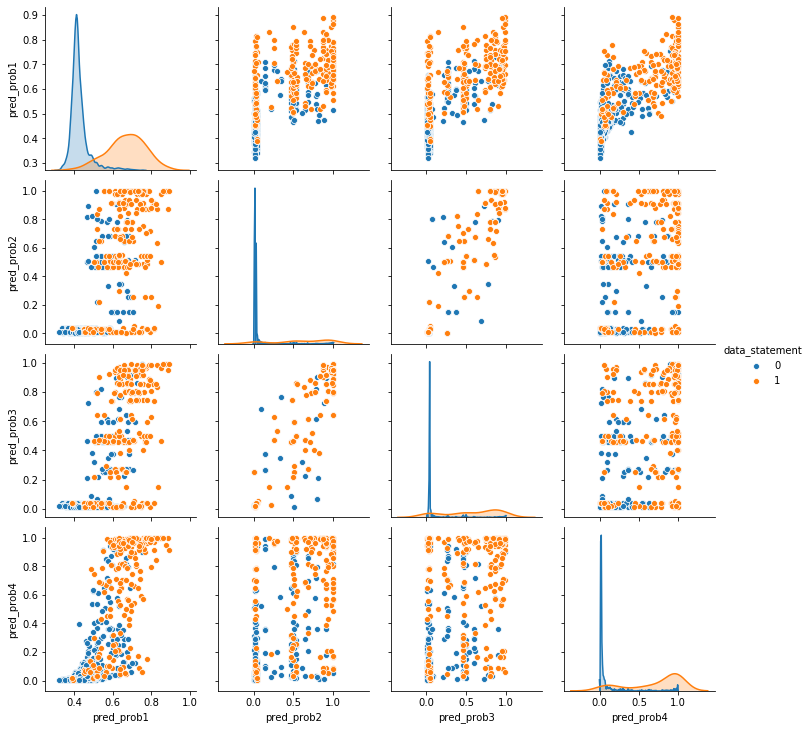

In [236]:
plot_dat = df[['pred_prob1', 'pred_prob2', 'pred_prob3', 'pred_prob4', 'data_statement']]
sns.pairplot(plot_dat, hue='data_statement')
df[['pred_prob1', 'pred_prob2', 'pred_prob3', 'pred_prob4', 'data_statement', 'text']].to_csv('/home/riddleta/temp_file.csv', index=False)

## Second level classifier

I looked at some of the predictions from the last batch to get a sense of what kinds of statements were being missed. It was a combination of mis-identifying software (again) and missing pretty obvious data statements. I thought I would just make a simple set of keywords that appeared to most closely align with those categories.

To the keywords, I added some of the features we identified previously as likely to be associated with repositories (e.g. keyword search of repos, whether there is a parenthetical, and whether there is a URL. After iteratively testing each of the predicted probabilities from the models above (plus all of them together), using the probabilities from the SVM alone resulted in the highest F1 score for the positive class. That's what I've implemented here. I also tried a couple of different classifiers for this, but settled with Logistic Regression as it seems to do the best. Obviously, I haven't done any tuning of hyperparameters here.

In [240]:
keywords = ['''software tool code package R python matlab SPM8 implement data 
                available dataset provided obtained deposited repository database
                download downloaded release released accession submit submitted
                public publically''']

cv.fit_transform(keywords)


<1x25 sparse matrix of type '<class 'numpy.int64'>'
	with 25 stored elements in Compressed Sparse Row format>

In [241]:
df['kw_code'] = df.text.apply(lambda x: code_kw(x))
df['kw_data'] = df.text.apply(lambda x: data_kw(x))
x_tr, x_tst, y_tr, y_tst = train_test_split(df.kw_code, df.data_statement, test_size=.33, random_state=42, stratify=df.data_statement)
cv_tr = cv.transform(df.text.loc[x_tr.index])
cv_tst = cv.transform(df.text.loc[x_tst.index])
one_hots_train = enc.fit_transform(df[['repo', 'has_parenth', 'has_url']].iloc[x_tr.index])
one_hots_test = enc.transform(df[['repo', 'has_parenth', 'has_url']].iloc[x_tst.index])
pred_probs_tr = df.pred_prob4.loc[x_tr.index]
pred_probs_tst = df.pred_prob4.loc[x_tst.index]
#x_tr = df[['pred_prob1', 'pred_prob2', 'pred_prob3', 'pred_prob4']].loc[x_tr.index]
#x_tst = df[['pred_prob1', 'pred_prob2', 'pred_prob3', 'pred_prob4']].loc[x_tst.index]

x_tr = pd.concat([pd.DataFrame(cv_tr.todense()), pd.DataFrame(one_hots_train.todense()), pred_probs_tr.reset_index()], axis=1)
x_tst = pd.concat([pd.DataFrame(cv_tst.todense()), pd.DataFrame(one_hots_test.todense()), pred_probs_tst.reset_index()], axis=1)

#x_tr = pd.concat([pd.DataFrame(cv_tr.todense()), pd.DataFrame(one_hots_train.todense()), x_tr], axis=1)
#x_tst = pd.concat([pd.DataFrame(cv_tst.todense()), pd.DataFrame(one_hots_test.todense()), x_tst], axis=1)
#x_tr = hstack([x_tr, one_hots_train, cv_tr])
#x_tst = hstack([x_tst, one_hots_test, cv_tst])

clf_log = LogisticRegression()
clf_log.fit(x_tr, y_tr)
y_pred = clf_log.predict(x_tst)
print(pd.crosstab(y_tst, y_pred, rownames=['True'], colnames=['Predicted']))
print(classification_report(y_tst, y_pred))

Predicted    0   1
True              
0          759   8
1           11  58
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       767
           1       0.88      0.84      0.86        69

    accuracy                           0.98       836
   macro avg       0.93      0.92      0.92       836
weighted avg       0.98      0.98      0.98       836



/home/riddleta/miniconda3/envs/data_sharing_reuse/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Next steps

Precision, recall, and f1 are all in the mid to upper .8 range. When I set out on this project, I kind of envisioned this as being roughly the upper limit of what we could do, with .9 as a kind of absolute maximum. Of course, I'm well aware that this is not exactly a clean test, as I've iteratively trained and tested a bunch of classifiers on the same data without having a dedicated hold-out set, so these numbers are likely to be slightly inflated, but I think it is still encouraging and we are close to having a usable system.

I think the next thing to do is to have another round of labeling and see how this pipeline performs on those labels. 

In [197]:
df['pred_prob_final'] = 0
for train_index, test_index in kfold.split(df.text, df.data_statement):
    x_train = cv.transform(df.text[train_index])
    one_hots_train = enc.fit_transform(df[['repo', 'has_parenth', 'has_url']].iloc[train_index])
    y_train = df.data_statement[train_index]
    x_test = cv.transform(df.text[test_index])
    one_hots_test = enc.transform(df[['repo', 'has_parenth', 'has_url']].iloc[test_index])
    y_test = df.data_statement[test_index]
    pred_probs_tr = df.pred_prob4.loc[train_index]
    pred_probs_tst = df.pred_prob4.loc[test_index]

    
    cv_tr_dense = pd.DataFrame(x_train.todense())
    one_hots_train_dense = pd.DataFrame(one_hots_train.todense())
    pred_probs_tr = pred_probs_tr.reset_index(drop=True)
    cv_tst_dense = pd.DataFrame(x_test.todense())
    one_hots_tst_dense = pd.DataFrame(one_hots_test.todense())
    pred_probs_tst = pred_probs_tst.reset_index(drop=True)
    
    x_tr = pd.concat([cv_tr_dense, one_hots_train_dense, pred_probs_tr], axis=1)
    x_tst = pd.concat([cv_tst_dense, one_hots_tst_dense, pred_probs_tst], axis=1)
    
    clf = LogisticRegression()
    y_score = clf.fit(x_tr, y_train)
    df['pred_prob_final'].loc[test_index] = clf.predict_proba(x_tst)[:,1]

/home/riddleta/miniconda3/envs/data_sharing_reuse/lib/python3.8/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/riddleta/miniconda3/envs/data_sharing_reuse/lib/python3.8/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/riddleta/miniconda3/envs/data_sharing_reuse/lib/python3.8/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation:

In [198]:
df[['text', 'data_statement', 'pred_prob1', 'pred_prob_final']].to_csv('/home/riddleta/tempfile.csv', index=False)

## below here is appendix code

after this, I'm using the high-recall classifier to apply labels to the population of papers. I didn't really do much with this, other than inspect the results.

In [34]:
nimh_papers = pd.read_csv('/data/riddleta/data_sharing_reuse/external/nimh_papers.csv')
#load file index
file_ix = pd.read_csv('/data/riddleta/data_sharing_reuse/external/file_index.csv')
file_ix['pmcid'] = file_ix.pmcid.astype('str')
nimh_papers['pmcid'] = nimh_papers.pmcid.astype('str')

/home/riddleta/miniconda3/envs/data_sharing_reuse/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [35]:
target_papers = file_ix[file_ix.pmcid.isin(nimh_papers.pmcid)]
target_papers.shape
target_papers = target_papers.sort_values('file')
status_prints = range(0, len(target_papers.file.tolist()), 250)
len(status_prints)

231

In [40]:
data_collect = []
last_file = np.nan
for i, file in enumerate(target_papers.file.tolist()):
    if i in status_prints:
        print(i)
    if file == last_file:
        paper = dat[target_papers.paper_number.iloc[i]]
        out_dat = return_passages(paper)
        data_collect.extend(out_dat)
    else:
        with open(file) as infile:
            dat = json.load(infile)
            paper = dat[target_papers.paper_number.iloc[i]]
            out_dat = return_passages(paper)
            data_collect.extend(out_dat)
            last_file = file

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750
5000
5250
5500
5750
6000
6250
6500
6750
7000
7250
7500
7750
8000
8250
8500
8750
9000
9250
9500
9750
10000
10250
10500
10750
11000
11250
11500
11750
12000
12250
12500
12750
13000
13250
13500
13750
14000
14250
14500
14750
15000
15250
15500
15750
16000
16250
16500
16750
17000
17250
17500
17750
18000
18250
18500
18750
19000
19250
19500
19750
20000
20250
20500
20750
21000
21250
21500
21750
22000
22250
22500
22750
23000
23250
23500
23750
24000
24250
24500
24750
25000
25250
25500
25750
26000
26250
26500
26750
27000
27250
27500
27750
28000
28250
28500
28750
29000
29250
29500
29750
30000
30250
30500
30750
31000
31250
31500
31750
32000
32250
32500
32750
33000
33250
33500
33750
34000
34250
34500
34750
35000
35250
35500
35750
36000
36250
36500
36750
37000
37250
37500
37750
38000
38250
38500
38750
39000
39250
39500
39750
40000
40250
40500
40750
41000
41250
41500
41750
42000
42250
42500
42750
43000
43250
43

In [43]:
df_pool = pd.DataFrame(data_collect)
df_pool.columns = ['context', 'paper_offset', 'pmcid', 'doi', 'section']
tk_file = open('/data/riddleta/data_sharing_reuse/external/tokenizer.pk', 'rb')
tokenizer = pickle.load(tk_file)
tk_file.close()
df_pool['context'] = df_pool.context.apply(lambda x: tokenizer.tokenize(x))
df_pool = df_pool.explode('context')
df_pool.shape# all sentence 18406892

(18406892, 5)

In [44]:
df_pool = df_pool[~df_pool.section.isin(['REF', 'TABLE', 'TITLE'])]
df_pmcids = pd.read_csv('/data/riddleta/data_sharing_reuse/external/PMC-ids.csv')
df_pmcids['pmcid'] = df_pmcids.PMCID.apply(lambda x: str(x)[3:])
df_pool = df_pool.merge(df_pmcids, how='left', on='pmcid')
df_pool['pmcid'] = df_pool.pmcid.astype('str')
df_pool['offset'] = df_pool.paper_offset.astype('str')
df_pool['pmcid-offset'] = df_pool.apply(lambda x: x['pmcid']+'-'+x['offset'], axis=1)
df_pool['context'] = df_pool.context.astype('str')
df_pool['text'] = df_pool.context.apply(lambda x: sep_urls(x))
df_pool['syn_text'] = df_pool.text.apply(lambda x: syns(x))
df_pool['all_text'] = df_pool.text + ' ' + df.syn_text

/home/riddleta/miniconda3/envs/data_sharing_reuse/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (4,5,10) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [45]:
df_pool.text.fillna('', inplace=True)
df_pool['has_url'] = df_pool.text.apply(lambda x: extract.has_urls(x))
df_pool['has_parenth'] = df_pool.text.apply(lambda x: check_paren(x))
df_pool['repo'] = df_pool.text.apply(lambda x: repo_label(x))
df_pool.all_text.fillna('', inplace=True)

In [46]:
x_pool = cv.transform(df_pool.all_text)
one_hots_pool = enc.transform(df_pool[['section', 'Journal Title', 'Year', 'has_url', 'has_parenth', 'repo']])

x_pool = hstack([x_pool, one_hots_pool])
y_pool_pred_prob = clf.predict_proba(x_pool)
y_pool_pred = clf.predict(x_pool)

In [65]:
df_pool['data_sharing_pred_prob'] = y_pool_pred_prob[:,1]
df_pool['data_sharing_pred'] = y_pool_pred
df_data_statements = df_pool[df_pool.data_sharing_pred==1]
statements_to_label = df_data_statements.sample(n=500, random_state=42)

In [68]:
statements_to_label['kw_code'] = statements_to_label.text.apply(lambda x: code_kw(x)) 

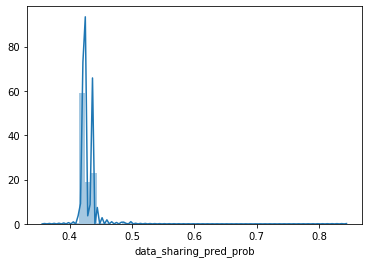

In [71]:
sns.distplot(df_pool.data_sharing_pred_prob, )

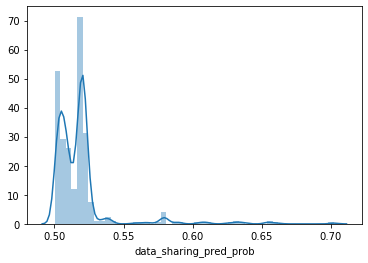

In [72]:
sns.distplot(statements_to_label.data_sharing_pred_prob)